In [4]:
import numpy as np
%matplotlib inline
import matplotlib.pyplot as plt

# Kernel density estimation #

Suppose we have a spatial temporal point process with intensity
$\lambda(t,x,y)$
supported on $[0,\infty) \times \mathbb R^2$.

We want an non-parametric estimate for these densities.  For this, we'll use a variable bandwidth Kernel Density Estimate method.  The standard form of this is as follows.

- Data points $(t_i, x_i, y_i)_{i=1}^N$
- Model $\lambda^*$ as a sum of Gaussians
$$ g(t,x,y) = \frac{1}{N} \sum_{i=1}^N \frac{1}{\sigma_t \sigma_x \sigma_y (2\pi)^{3/2} D_i^3}
\exp\Big( -\frac{(t_i-t)^2}{2\sigma_t^2D_i^2}-\frac{(x_i-x)^2}{2\sigma_x^2D_i^2}-\frac{(y_i-y)^2}{2\sigma_y^2D_i^2} \Big) $$
- Here $D_i$ is a scale parameter to be chosen.

A standard procedure for choosing $D_i$ is via "nearest neighbours":

- Fix some $k$.  Typically $k$ will be between 10 and 100.
- Scale the data to have unit variance in each coordinate.
- Let $D_i$ the the distance from the point $i$ to the $k$th nearest neighbour of $i$.

# Example #

As we can only visualise 2 dimensions at once (easily...) we will suppress $y$.

Let us choose
$$ \lambda(t,x,y) = \frac{\omega}{\sqrt{2\pi \sigma_x^2}} e^{-\omega t} \exp\Big(-\frac{x^2}{2\sigma_x^2}\Big). $$
Here we can vary $\omega, \sigma_x$.

- For example, $\omega=1, \sigma_x=10$

We will look at a window $[0,5] \times [-30,30]$

## Simulation one ##

We treat $t$ and $x$ symmetrically, and use a rejection sampling technique.

In [5]:
omega = 1
sigma_x = 10
window = [[0,5], [-30,30]]

actual_kernel_max = omega / sigma_x / np.sqrt(np.pi * 2.0)
window_size = (window[0][1] - window[0][0]) * (window[1][1] - window[1][0])
def actual_kernel(t,x):
    k = actual_kernel_max * np.exp(-omega * t)
    return k * np.exp(-x*x / (2 * sigma_x * sigma_x))

def trial():
    t = np.random.uniform(low=window[0][0], high=window[0][1])
    x = np.random.uniform(low=window[1][0], high=window[1][1])
    if actual_kernel(t,x) >= np.random.uniform(low=0, high=actual_kernel_max):
        return (t,x)
    return None

def rejection_sample(rate):
    number_points = np.random.poisson(rate * window_size * actual_kernel_max)
    points = []
    for _ in range(number_points):
        p = trial()
        if p != None:
            points.append(p)
    return np.array(points)

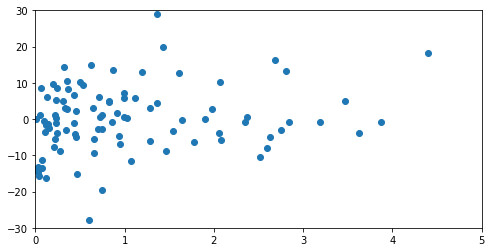

In [6]:
fig, ax = plt.subplots(nrows=1, ncols=1, figsize=plt.figaspect(.5))

ax.set(xlim=window[0], ylim=window[1])
points = rejection_sample(100)
ax.scatter(x=points[:,0], y=points[:,1])

## Simulation two ##

We simulate a marked process with (time) density $\lambda^*(t)=\omega e^{-\omega t}$ and space density the Gaussian.  Here we can use the "inverse method" as
$$ \Lambda^*(s) = \int_0^s \lambda^*(t) \ dt = 1 - e^{-\omega s} $$
and solving $t = \Lambda^*(s)$ gives $s = -\frac{1}{\omega} \log(1-t)$.

In [7]:
omega = 1
sigma_x = 10
window = [[0,5], [-30,30]]

def process_simulate(rate):
    points = []
    t = 0
    while t < 1:
        t += np.random.exponential(scale = 1 / rate)
        if t < 1:
            s = - np.log(1-t) / omega
            x = np.random.normal(scale=sigma_x)
            if s <= window[0][1] and x >= window[1][0] and x <= window[1][1]:
                points.append( [s,x] )
    return np.array(points)

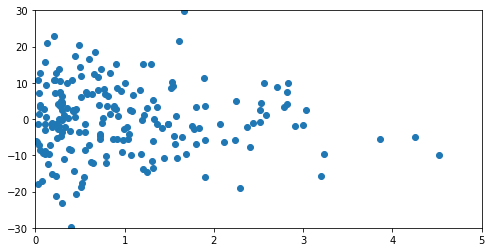

In [8]:
fig, ax = plt.subplots(nrows=1, ncols=1, figsize=plt.figaspect(.5))

ax.set(xlim=window[0], ylim=window[1])
points = process_simulate(200)
_ = ax.scatter(x=points[:,0], y=points[:,1])

# Kernel density estimation #

For production code, should look at `scipy.spatial`

In [9]:
def rescale(points):
    """Returns a copy of the input data rescaled to have unit variance in each coordinate"""
    means = np.mean(points, axis=0)
    stds = np.std(points, axis=0)
    return (np.copy(points) - means) / stds

x = np.random.random((10, 2))
x = rescale(x)
assert( all(np.isclose(0, np.mean(x, axis=0))) )
assert( all(np.isclose(1, np.std(x, axis=0))) )

In [10]:
def find_knn(points, k, point):
    """Returns the distance from `point` to its `k`th nearest neighbour in `points`"""
    num_points = points.shape[0]
    if k >= num_points:
        raise Exception("Not enough points to return {}th neighbour!", k)
    distances = np.empty(num_points)
    for i, p in enumerate(points):
        distances[i] = np.linalg.norm(p - point)
    distances.sort()
    return distances[k]

def distance_to_knn(points, k):
    """For each point, find the `k`th nearest neighbour, and return the (Euclidean) distance"""
    distances = np.empty(points.shape[0])
    for i, p in enumerate(points):
        distances[i] = find_knn(points, k, p)
    return distances

In [11]:
def compute_kernel(points, k=10):
    """Returns a function object which can be evaluated at a list-like object representing coordinates"""
    dist = distance_to_knn(rescale(points), k)
    stds = np.std(points, axis=0)
    rescale_factor = np.tensordot(dist, stds, axes=0)
    def kernel(c):
        coord = np.array(c)
        rs = (rescale_factor ** 2) * 2
        powers = -(points - coord)**2 / rs
        normalisation = rescale_factor
        pi_factor = np.sqrt(2 * np.pi)
        if len(points.shape) > 1:
            powers = np.sum(powers, axis=1)
            normalisation = np.prod(normalisation, axis=1)
            pi_factor = pi_factor ** points.shape[1]
        summands = np.exp(powers) / normalisation / pi_factor
        return np.mean(summands)
    return kernel

In [12]:
k = compute_kernel(points, k=15)

import scipy.integrate
def ker(t,x):
    return k([t,x])
k_norm = scipy.integrate.nquad(ker, [[0,5],[-30,30]])[0]

def from_computed_kernel():
    Z = np.empty((100,100))
    for x in range(100):
        for y in range(100):
            xx, yy = x/100*5, y/100*60 - 30
            Z[x][y] = k( [xx,yy] ) / k_norm
    return Z

def from_actual_kernel():
    Z = np.empty((100,100))
    for x in range(100):
        for y in range(100):
            xx, yy = x/100*5, y/100*60 - 30
            Z[x][y] = omega * np.exp(-xx*omega) * np.exp(-(yy/sigma_x)**2/2) / np.sqrt(2*np.pi*sigma_x**2)
    return Z

[(-30, 30), (0, 5), <matplotlib.text.Text at 0x7f041cb84be0>]

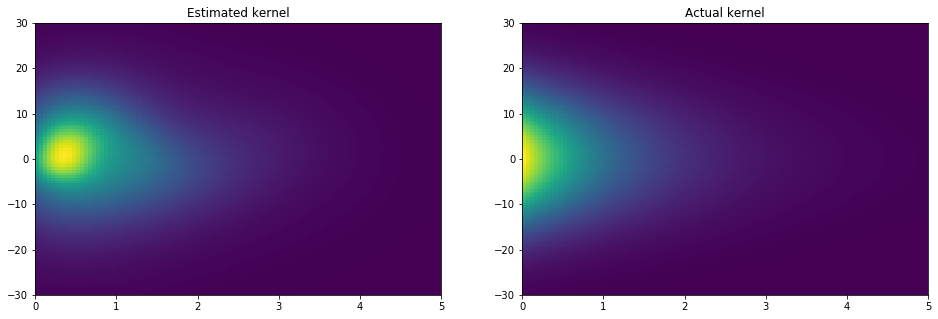

In [13]:
fig, ax = plt.subplots(ncols=2, figsize=(plt.figaspect(.1)[0], 5))

Z = from_computed_kernel()
ax[0].imshow(np.rot90(Z), extent=[0, 5, -30, 30], aspect="auto") # cmap=plt.cm.gist_earth_r, 
ax[0].set(xlim=[0,5], ylim=[-30,30], title="Estimated kernel")

Z = from_actual_kernel()
ax[1].imshow(np.rot90(Z), extent=[0, 5, -30, 30], aspect="auto") # cmap=plt.cm.gist_earth_r, 
ax[1].set(xlim=[0,5], ylim=[-30,30], title="Actual kernel")

[(-30, 30), <matplotlib.text.Text at 0x7f041caa5748>]

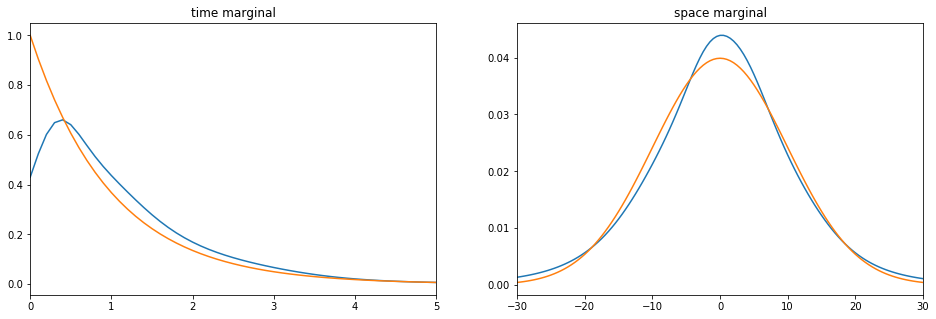

In [14]:
def t_marginal(t):
    return scipy.integrate.quad(lambda x : ker(t,x),-50,50)[0] / k_norm
def x_marginal(x):
    return scipy.integrate.quad(lambda t : ker(t,x),0,50)[0] / k_norm

fig, ax = plt.subplots(ncols=2, figsize=(plt.figaspect(.1)[0], 5))

x = np.arange(0,5.1,0.1)
y = [t_marginal(t) for t in x ]
ax[0].plot(x,y)
ax[0].plot(x,[omega*np.exp(-t*omega) for t in x])
ax[0].set(xlim=[0,5], title="time marginal")

x = np.arange(-30,30.5,0.5)
y = [x_marginal(t) for t in x]
ax[1].plot(x,y)
ax[1].plot(x,[np.exp(-(t/sigma_x)**2/2) / np.sqrt(2*np.pi*sigma_x**2) for t in x])
ax[1].set(xlim=[-30,30], title="space marginal")

We can see here that the asymmetry about $t=0$ causes problems in the estimation, as we are using a symmetric kernel in our estimation.

# One dimensional visualisations #

To get a better sense of what the algorithm is doing, we perform some one dimensional visualisations.

Firstly, pick samples from a normal distribution.  As some (a few) data points will fall in time less than 0, we clamp the data, and rescale the densities.  More on this problem shortly.

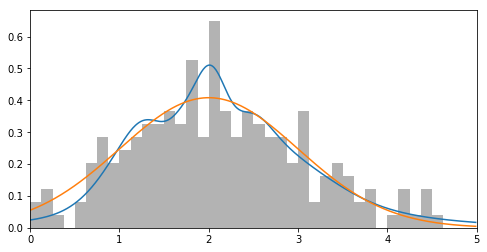

In [27]:
import scipy.integrate

def pretty_plot_kernel(points, actual_kernel, k=25):
    kernel = compute_kernel(points, k)
    pretty_plot_kernel2(kernel, points, actual_kernel)

def pretty_plot_kernel2(kernel, points, actual_kernel):
    k_norm = 1 / scipy.integrate.quad(kernel,0,100)[0]
    l_norm = 1 / scipy.integrate.quad(actual_kernel,0,100)[0]

    assert(np.isclose(1, scipy.integrate.quad(kernel, -100, 100)[0]))
    
    fig, ax = plt.subplots(nrows=1, ncols=1, figsize=plt.figaspect(.5))

    bins = np.arange(41)/8
    counts, _ = np.histogram(points, bins)
    bin_width = bins[1] - bins[0]
    ax.bar(left=bins[:-1] + bin_width/2, height=counts / len(points) / bin_width, width=bin_width, color="0.7")

    x = np.arange(0,5,0.01)
    y = [k_norm * kernel(t) for t in x]
    ax.plot(x,y)

    y = [l_norm * actual_kernel(t) for t in x]
    ax.plot(x,y)

    _ = ax.set(xlim=[0,5])

points = np.random.normal(loc=2.0, scale=1.0, size=200)
points = points[ points>=0 ]
def actual_kernel(x):
    return np.exp(-(x-2)**2 / 2) / np.sqrt((2*np.pi))
pretty_plot_kernel(points, actual_kernel)

As a second example, let us consider a distribution which is definitely not symmetric.

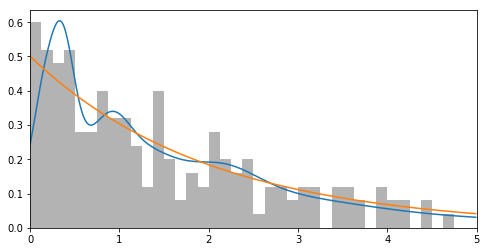

In [29]:
exp_scale = 2
points = np.random.exponential(scale=exp_scale, size=200)
def l(x):
    return np.exp(- x / exp_scale) / exp_scale
pretty_plot_kernel(points, l)

What is characteristic here is that the estimated kernel (blue) drops off at $t=0$.  This is more pronounced is we smooth more, that is, consider more nearest neighbours in each point estimate.

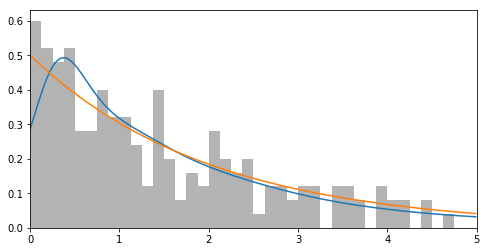

In [30]:
pretty_plot_kernel(points, l, k=50)

## Symmetrise the time data ##

One idea to get around this problem is to reflect the data about 0, fit a kernel to symmetric data, and then reflect the kernel back.  Actually, as everything is now symmetric, the estimated kernel is gauranteed to be symmetric about 0.

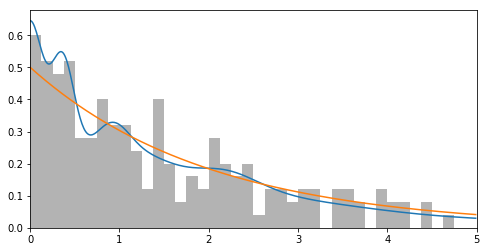

In [36]:
reflected_points = np.array( list(points) + [-x for x in points] )
kernel = compute_kernel(reflected_points, k=25)
pretty_plot_kernel2(kernel, points, l)

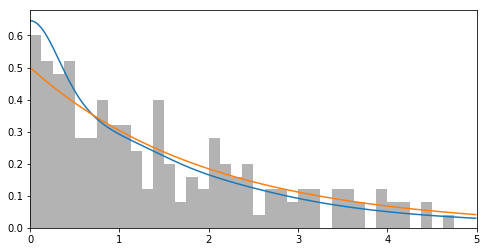

In [38]:
kernel = compute_kernel(reflected_points, k=50)
pretty_plot_kernel2(kernel, points, l)

# How many samples to trial #

The rejection sampling technique has the following input:

- A window $W$
- A density $\mu$ with $\mu \leq \mu_\max$ almost surely.  We shall not assume that $\mu$ is normalised in any sense.

The algorithm is then:

- Pick $N$ the number of points, $N \sim \operatorname{Poi}(\lambda)$
- Choose $(x_i)_{i=1}^{N}$ uniformly at random in $W$.  So $(x_i)$ is a realisation of a homogeneous Poisson process in $W$ with total rate $\lambda$
- For each $i$ we pick uniformly at random $y_i \in [0,\mu_\max]$
- We "accept" $x_i$ if $y_i \leq \mu(x_i)$; otherwise discard $x_i$.

If $y\sim U[0,\mu_\max]$ and $x$ uniformly chosen in $W$ are independent, then $\mathbb P(y\leq \mu(x))$ is the volume of
$[0,\mu_\max]\times W$ bounded by the density $\mu$, that is,
$$ \alpha := \frac{1}{|W| \mu_\max}  \int_W \mu(x) \ dx.$$
Hence
$$ \mathbb E(\text{Acceptances} | N) = N \mu_0, $$
and so
$$ \mathbb E(\text{Acceptances}) = \sum_n \mathbb P(N=n) n\mu_0 = \lambda \mu_0. $$

We can hence adjust $\lambda$ to obtain the expected overall "rate".

## Example ##

If $\mu$ is a probability density, and $W$ contains nearly all the mass of $\mu$ then $\int_W \mu \approx 1$ and so we expect to have about $\lambda / |W|\mu_\max$ acceptances.